In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import pandas as pd
from tqdm import tqdm

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica Neue"],
    "font.size": 20,
})
np.random.seed(0)

In [2]:
# Load data from MNIST dataset (please uncompress data.zip)
# in csv format (Kaggle) 
# https://www.kaggle.com/oddrationale/mnist-in-csv/home
# First column = Label
# Other columns = Image
df_train = pd.read_csv('data/mnist_train.csv', header=None, index_col=None)
df_test  = pd.read_csv('data/mnist_test.csv',  header=None, index_col=None)

# Reduce size (to reduce size computations)
df_train = df_train.iloc[:3000]
df_test  = df_test.iloc[:1000]

# Split data in X and y
X_train, y_train = df_train.iloc[:, 1:], df_train.iloc[:, 0]
X_test,  y_test  = df_test.iloc[:,  1:], df_test.iloc[:, 0]

In [3]:
# a function to return a classifier (a,b)

def make_classifier(target_integer, X, y):
    
    X = X.to_numpy()
    n = np.size(X,1)

    s = (y == target_integer).astype(int).to_numpy()  #converts to 0/1
    s[s == 0] = -1 
    
    #pose and solve SVM problem
    lam = 0.25
    a = cp.Variable(n)
    b = cp.Variable()
    loss = cp.sum(cp.pos(1 - cp.multiply(s, X @ a + b)))/len(s)
    reg  = cp.norm(a,1)
    problem = cp.Problem(cp.Minimize(loss + lam * reg))
    problem.solve(solver='ECOS')
    
    #return classifier
    return a.value, b.value


## Make a SVM classifier for every digit 0--9



In [4]:
svm_a = []
svm_b = []

for i in tqdm(range(10)):
 thisa,thisb = make_classifier(i,X_train,y_train)
 svm_a.append(thisa)
 svm_b.append(thisb)


100%|██████████| 10/10 [00:38<00:00,  3.84s/it]


In [5]:
def predict(X, a, b):
    
    values = np.zeros(10)
    for i in range(10):
        values[i] = X.dot(a[i]) + b[i]
    
    #prediction is the SVM with the highest value
    return np.argmax(values)

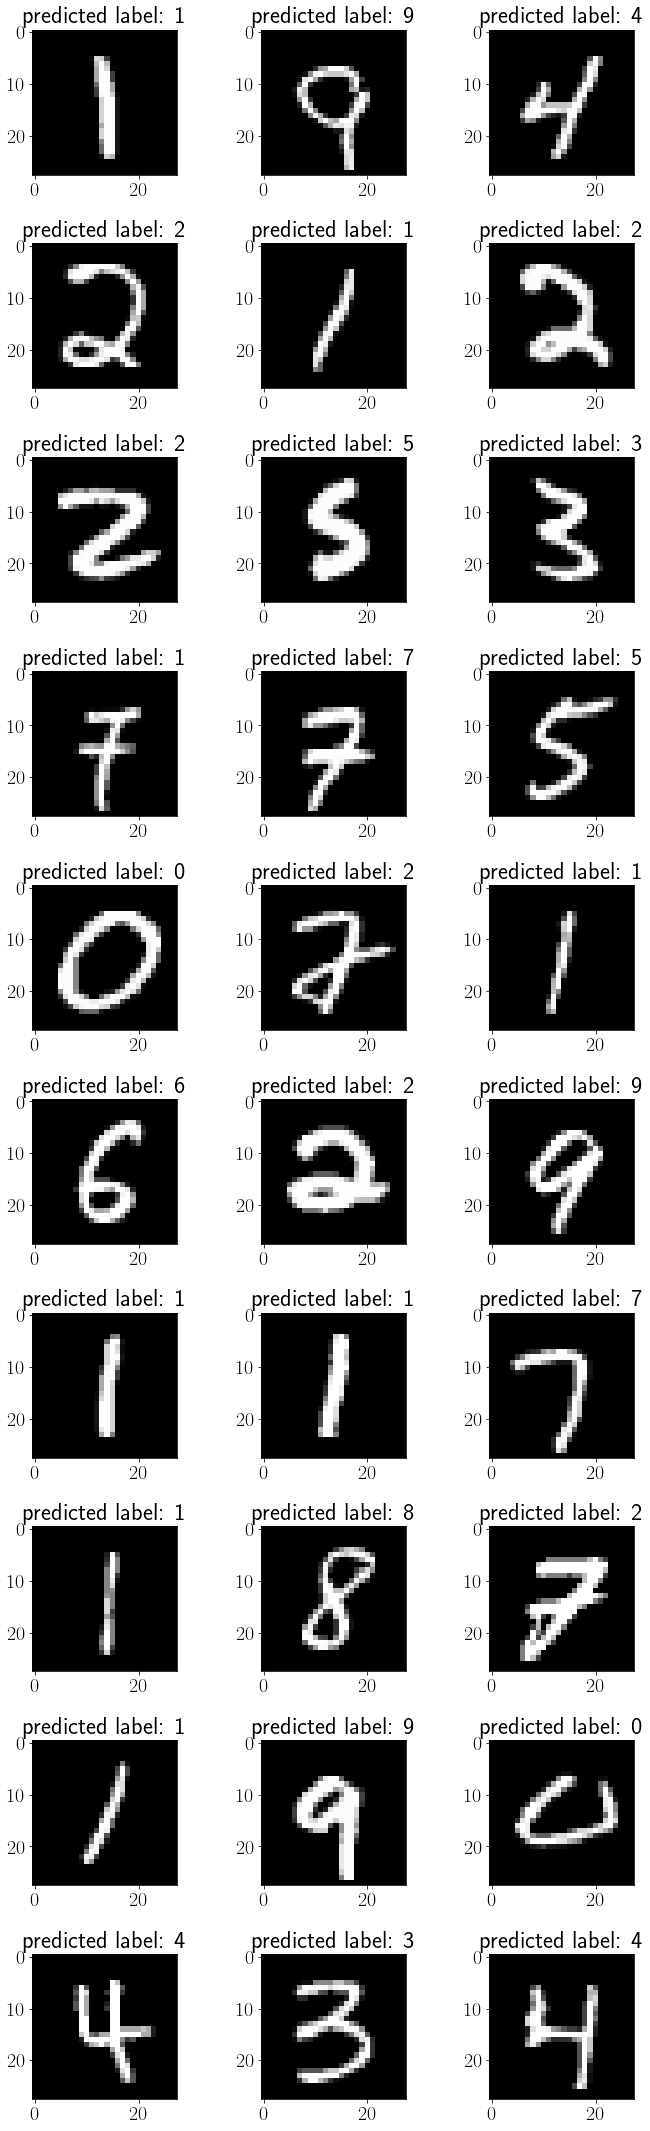

In [6]:
rows = 10
cols = 3

np.random.seed(1)
fig, ax  = plt.subplots(rows, cols, figsize=(10, 50))
rand_idx = np.random.randint(0, len(y_test), rows*cols)

axes = ax.ravel()

for i in range(rows*cols):
    idx   = rand_idx[i]
    ax    = axes[i]
    xtest = X_test.to_numpy()[idx];
    
    #predicted value
    predInt = predict(xtest, svm_a, svm_b)
    
    #plot it and show the prediction
    x_i = np.reshape(xtest, (-1, 28))
    ax.set_title('predicted label: %i' %predInt)
    ax.imshow(x_i, cmap='gray')
    
plt.tight_layout()

## Visualize the weights in the different classifiers

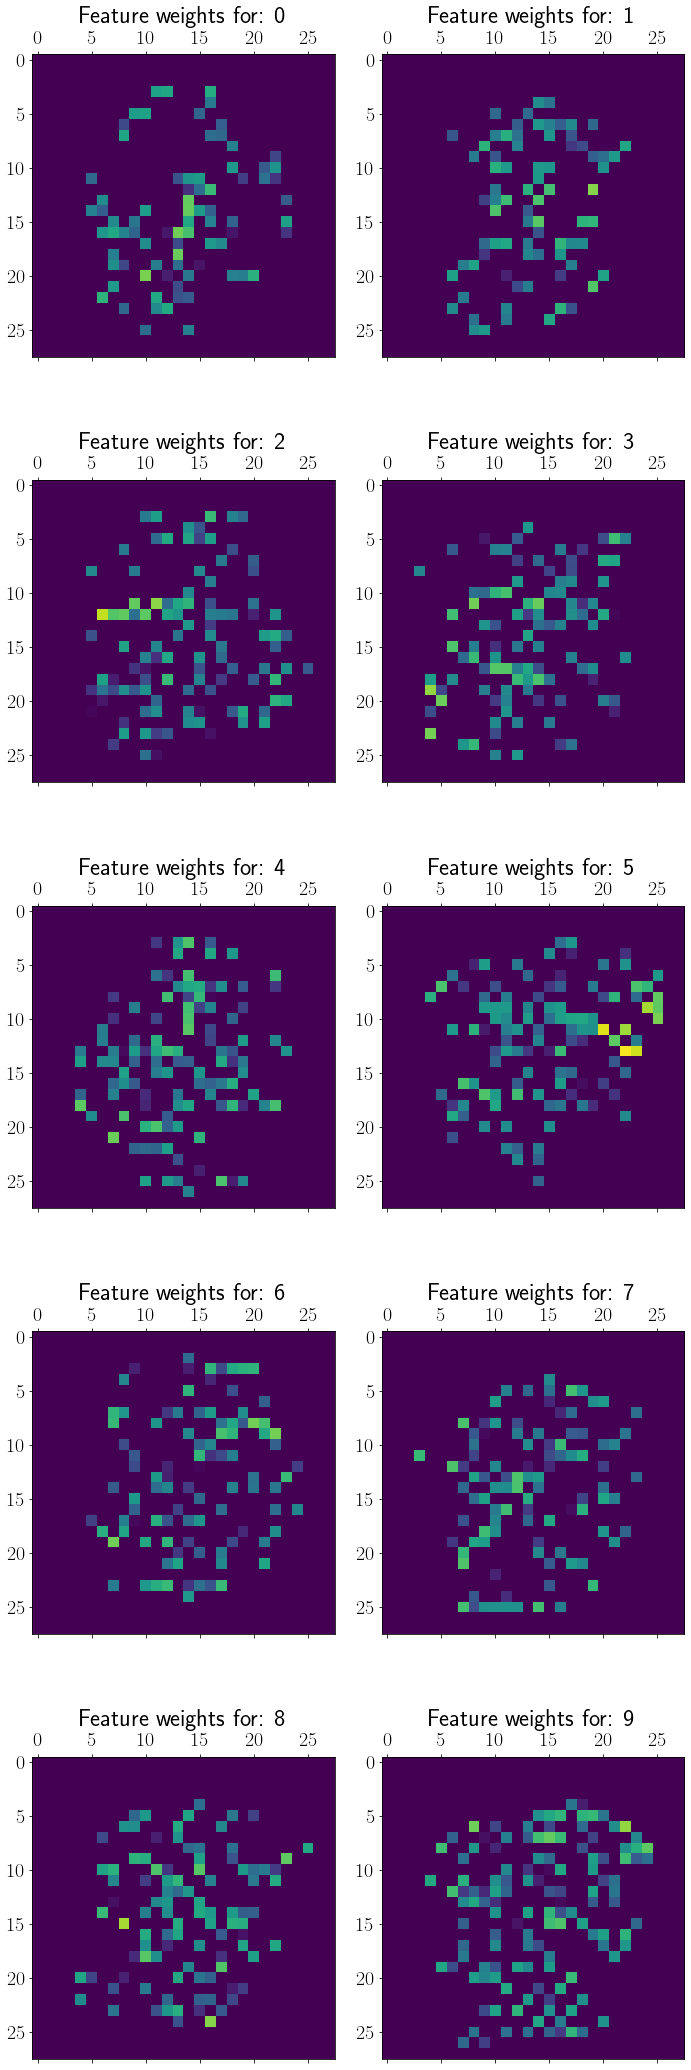

In [7]:
from pylab import figure, cm
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(5, 2, figsize=(10, 30))
axes = ax.ravel()

for i in range(10):
    thisa = abs(svm_a[i])
    thisa = np.reshape(thisa, (-1, 28))
    axes[i].set_title('Feature weights for: %i' %i)
    axes[i].matshow(thisa, norm=LogNorm(vmin=1e-4, vmax=1e-2))
    
plt.tight_layout()